In [1]:
import zipfile #Библиотека для работы с zip архивами
import os # Библиотека для работы с файловой системой
from google.colab import drive # Модуль для работы с Google Disc

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
!pip install keras
!pip install keras_preprocessing
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [3]:
# Подключаем GoogleDisc
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Прописываем путь к файлу с архивом
zip_file = '/content/drive/MyDrive/archive.zip'

# Распаковываем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

# Просмотр результата разархивации
print(os.listdir())

['.config', 'train', 'test', 'valid', 'EfficientNetB0-525-(224 X 224)- 98.97.h5', 'birds.csv', 'drive', 'sample_data']


In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Импорт ряда вспомогательных функций для нашего ноутбука
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-01-19 05:39:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-19 05:39:17 (85.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [6]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [7]:
# Пройдемся по каждму каталогу
dataset = "/content/train"
walk_through_dir(dataset);

There are 525 directories and 0 images in '/content/train'.
There are 0 directories and 140 images in '/content/train/RAINBOW LORIKEET'.
There are 0 directories and 185 images in '/content/train/BLUE GROUSE'.
There are 0 directories and 153 images in '/content/train/WHITE CHEEKED TURACO'.
There are 0 directories and 185 images in '/content/train/CANVASBACK'.
There are 0 directories and 196 images in '/content/train/NORTHERN PARULA'.
There are 0 directories and 190 images in '/content/train/DUNLIN'.
There are 0 directories and 176 images in '/content/train/GREEN MAGPIE'.
There are 0 directories and 150 images in '/content/train/HIMALAYAN BLUETAIL'.
There are 0 directories and 180 images in '/content/train/CEDAR WAXWING'.
There are 0 directories and 150 images in '/content/train/ALTAMIRA YELLOWTHROAT'.
There are 0 directories and 154 images in '/content/train/EARED PITA'.
There are 0 directories and 136 images in '/content/train/RED BROWED FINCH'.
There are 0 directories and 197 images i

Первый столбец filepaths содержит расположение пути к файлу каждого отдельного изображения. Второй столбец labels, с другой стороны, содержит метку класса соответствующего изображения из пути к файлу

In [8]:
image_dir = Path(dataset)

# Получить пути к файлам и метки
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Объединять пути к файлам и метки
image_df = pd.concat([filepaths, labels], axis=1)

<ipython-input-9-7c5216a8ddb0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')


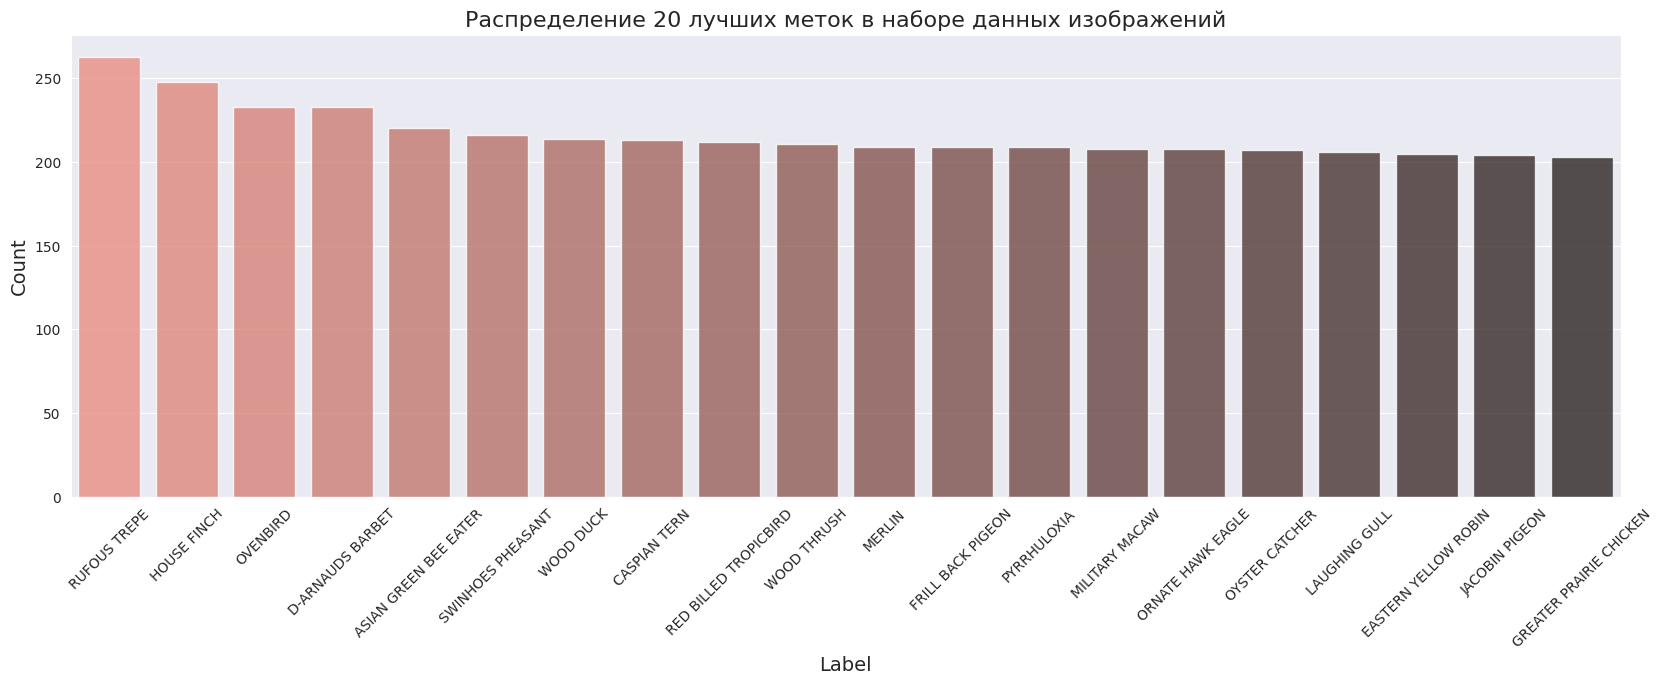

In [9]:
# Получите 20 лучших лейблов
label_counts = image_df['Label'].value_counts()[:20]

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')
plt.title('Распределение 20 лучших меток в наборе данных изображений', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

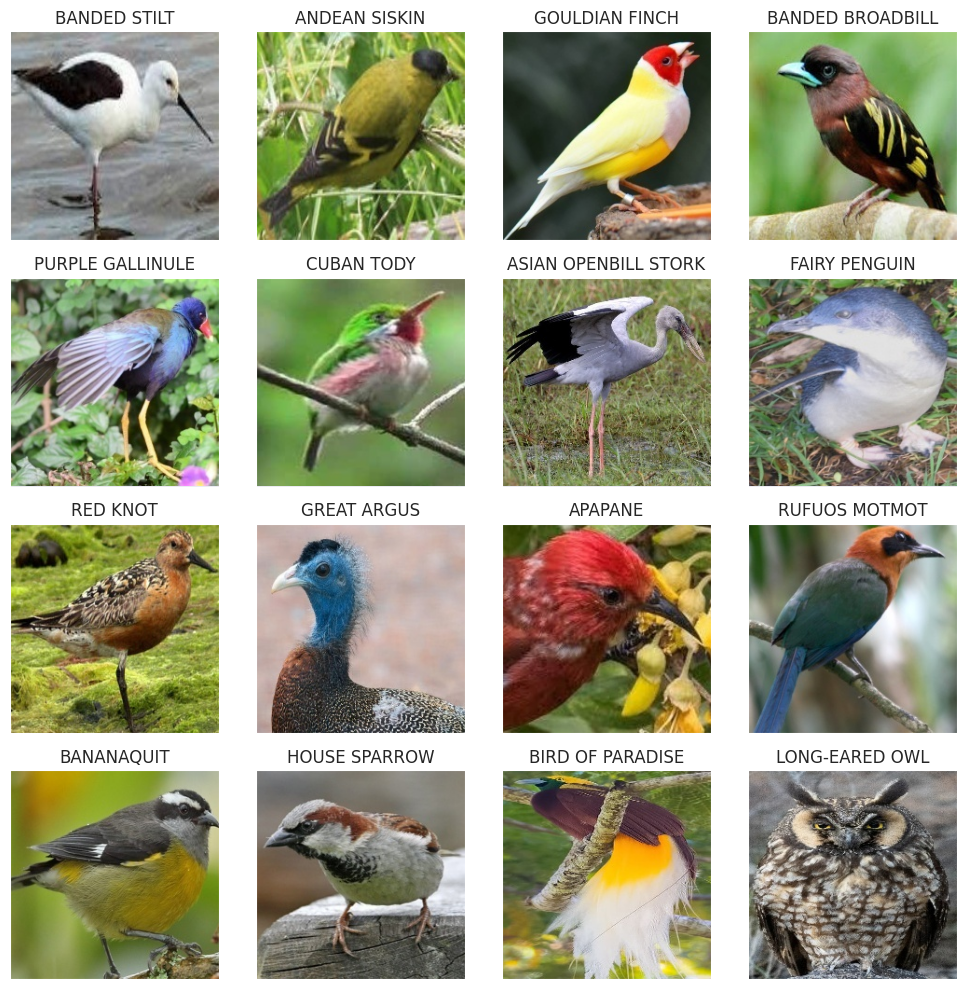

In [10]:
# Отобразить 16 изображений набора данных с их метками
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

Анализ частоты вычислительных ошибок
Приведенный ниже код используется для анализа уровня ошибок (ELA) изображений в контексте задачи классификации изображений животных.

Функция compute_ela_cv() принимает путь к изображению и параметр качества, сжимает изображение с использованием сжатия JPEG с заданным качеством и вычисляет абсолютную разницу между сжатым и исходным изображениями. Разница умножается на масштабный коэффициент и возвращается в виде изображения ELA.

Функция convert_to_ela_image() принимает путь к изображению и параметр качества, сжимает изображение с использованием сжатия JPEG с заданным качеством, вычисляет абсолютную разницу между сжатым и исходным изображениями и возвращает изображение ELA. Изображение ELA вычисляется с использованием разницы в значениях пикселей между исходным и сжатым изображениями и нормализуется для усиления различий.

Функция random_sample() принимает путь к каталогу и необязательное расширение файла и возвращает случайный путь к файлу из этого каталога с указанным расширением (если указано).

Наконец, код генерирует набор изображений ELA, используя функцию compute_ela_cv() для случайно выбранного изображения из тестового набора данных изображений животных. Изображения ELA генерируются с понижающимся уровнем качества, что приводит к повышению уровня сжатия и, следовательно, к увеличению уровня ошибок. Результирующие изображения отображаются с использованием matplotlib.

В целом, этот код предоставляет способ визуального анализа влияния различных уровней сжатия JPEG на изображения животных и может быть использован для определения оптимальных уровней качества для сжатия изображений в контексте задачи классификации изображений животных.

In [11]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

# считывание сжатого изображения
    compressed_img = cv2.imread(temp_filename)

 # получите абсолютную разницу между img1 и img2 и умножьте на масштаб
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

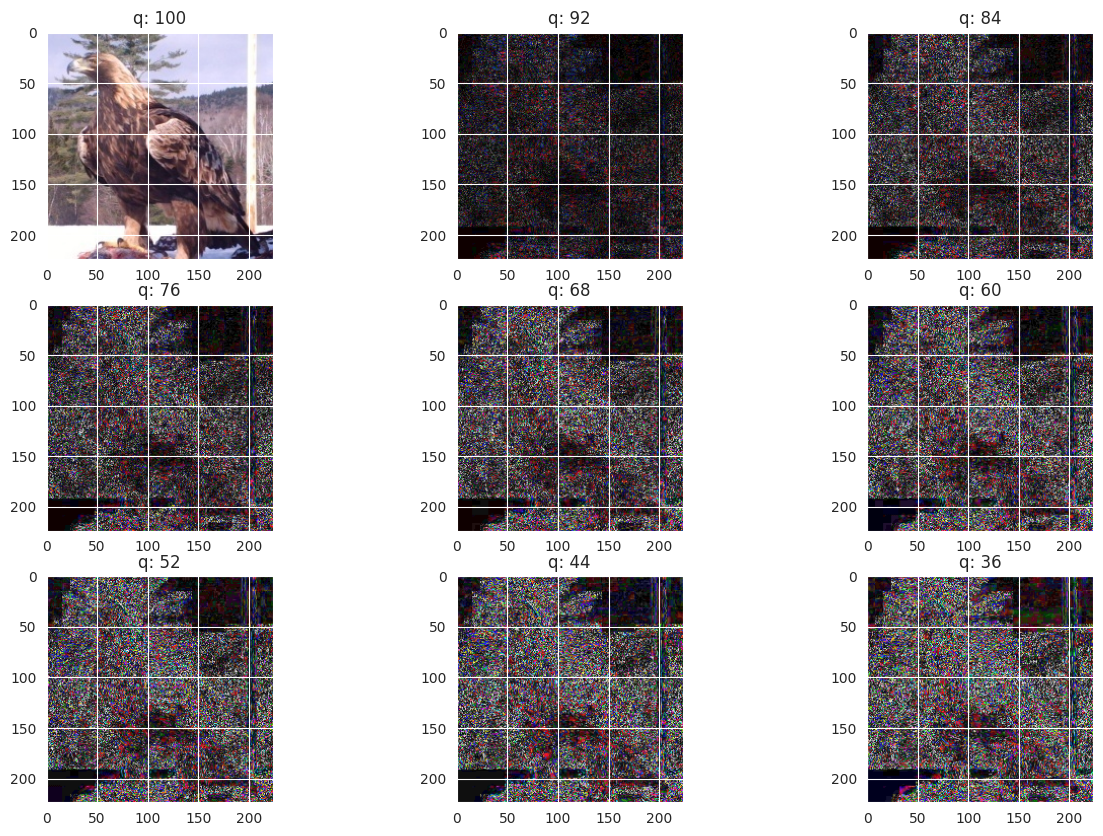

In [12]:
# Просмотр случайной выборки из набора данных
p = random_sample('/content/test/GOLDEN EAGLE')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

Предварительная обработка данных.

Данные будут разделены на три различные категории: Обучение, валидация и тестирование. Данные обучения будут использоваться для обучения модели CNN глубокого обучения, и ее параметры будут точно настроены с учетом данных валидации. Наконец, производительность данных будет оценена с использованием тестовых данных (данных, которые модель ранее не видела).

In [13]:
# Разделять данные о тренировках и тестах
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [14]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [15]:
# Разделите данные на три категории.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 54167 validated image filenames belonging to 525 classes.
Found 13541 validated image filenames belonging to 525 classes.
Found 16927 validated image filenames belonging to 525 classes.


In [16]:
#Шаг увеличения данных
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

Обучение модели
Изображения модели будут обработаны предварительно обученной моделью CNN под названием Efficient Net B 0. Для мониторинга обучения будут использоваться три обратных вызова. Это: Контрольная точка модели, ранняя остановка, обратный вызов Tensorboard. Краткое описание гиперпараметра модели показано следующим образом:
Batch size: 32
Epochs: 25
Input Shape: (224, 224, 3)
Output layer: 525

In [17]:
#Загрузите предварительно обученную модель
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [18]:
# Создать обратный вызов контрольной точки
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)
'''Настройте обратный вызов ранней остановки,
чтобы остановить обучение, если значение val_loss модели не улучшается в течение 3 эпох'''
early_stopping = EarlyStopping(monitor = "val_loss", # следите за показателем val_loss
                               patience = 5,
                               restore_best_weights = True) # если val_loss уменьшается в течение 3 эпох подряд, прекратите тренировку

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

Обучение модели

In [19]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(525, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=25,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bird_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/bird_classification/20240119-054158
Epoch 1/25
1693/1693 [==============================] - 193s 106ms/step - loss: 6.2023 - accuracy: 0.0090 - val_loss: 5.6015 - val_accuracy: 0.0661 - lr: 1.0000e-04
Epoch 2/25
1693/1693 [==============================] - 173s 102ms/step - loss: 5.2136 - accuracy: 0.0618 - val_loss: 3.7963 - val_accuracy: 0.3084 - lr: 1.0000e-04
Epoch 3/25
1693/1693 [==============================] - 156s 92ms/step - loss: 4.2801 - accuracy: 0.1307 - val_loss: 2.7704 - val_accuracy: 0.4945 - lr: 1.0000e-04
Epoch 4/25
1693/1693 [==============================] - 155s 91ms/step - loss: 3.7351 - accuracy: 0.1904 - val_loss: 2.1802 - val_accuracy: 0.5971 - lr: 1.0000e-04
Epoch 5/25
1693/1693 [==============================] - 156s 92ms/step - loss: 3.3626 - accuracy: 0.2410 - val_loss: 1.8297 - val_accuracy: 0.6558 - lr: 1.0000e-04
Epoch 6/25
1693/1693 [==============================] - 158s 93ms/step - loss: 3.0697 - accurac

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.60828
Test Accuracy: 85.96%


📉Визуализация кривых потерь


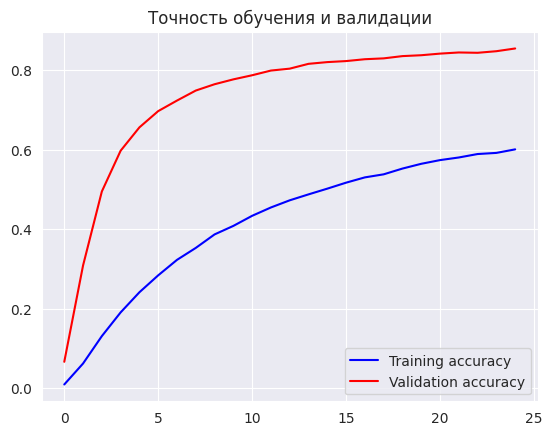

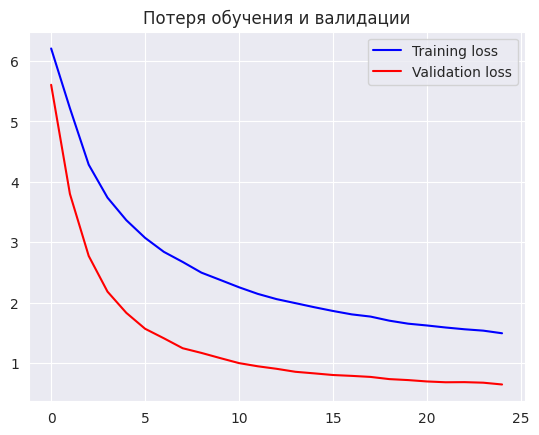

In [20]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Точность обучения и валидации')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Потеря обучения и валидации')
plt.legend()
plt.show()

Составление прогнозов на основе тестовых данных

In [21]:
# Предсказать метку тестовых изображений
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Сопоставьте метку
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Отобразить результат
print(f'The first 5 predictions: {pred[:5]}')

529/529 [==============================] - 46s 84ms/step
The first 5 predictions: ['BELTED KINGFISHER', 'BLUE GROUSE', 'COMMON POORWILL', 'BALTIMORE ORIOLE', 'SHOEBILL']


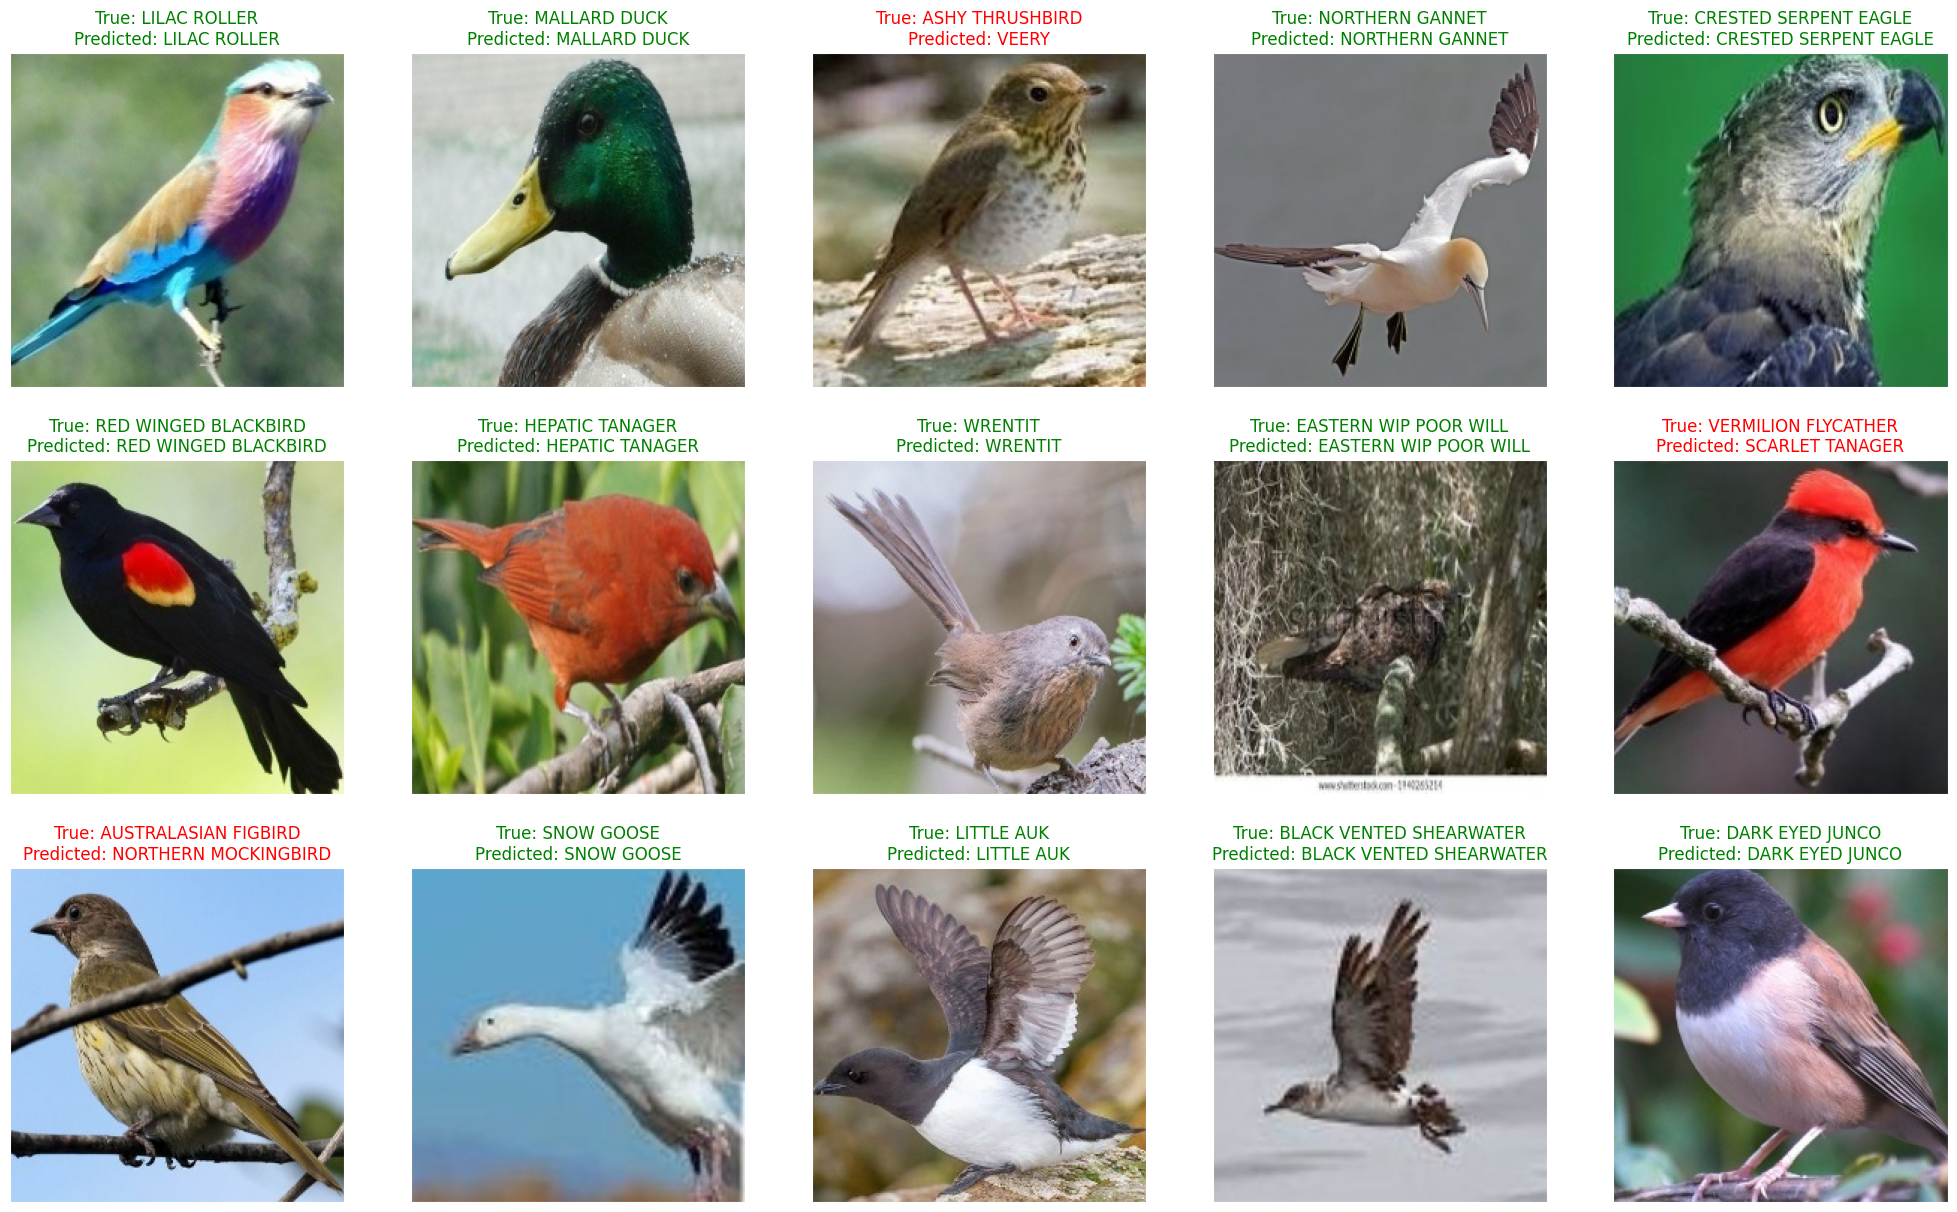

<Figure size 640x480 with 0 Axes>

In [22]:
# Отобразить 25 случайных изображений из набора данных с их надписями
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

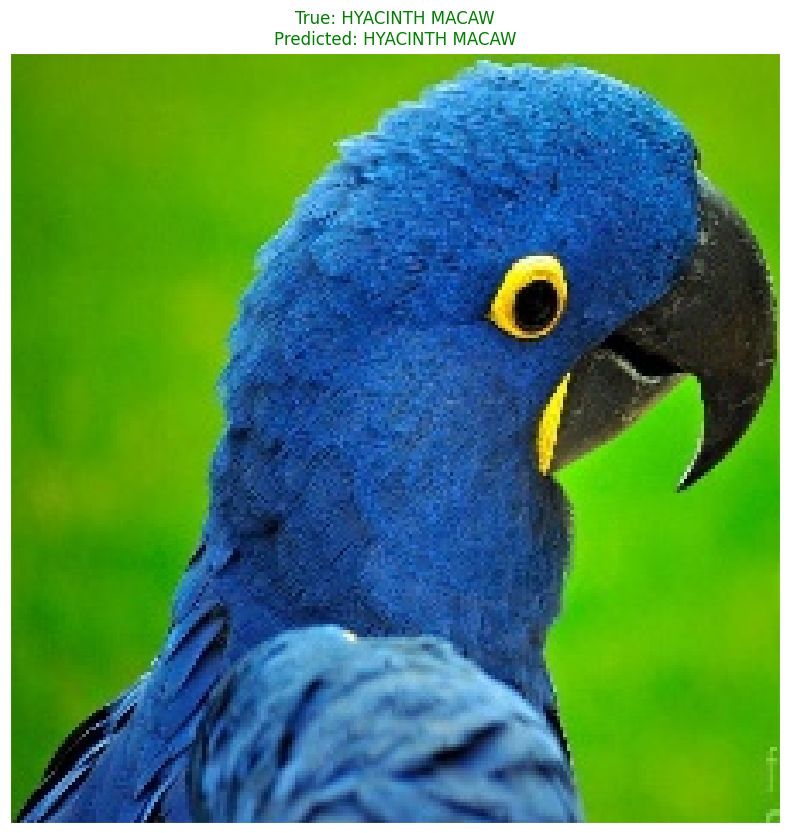

In [28]:
index = np.random.randint(0, len(test_df) - 1)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

ax = axes
ax.imshow(plt.imread(test_df.Filepath.iloc[index]))
if test_df.Label.iloc[index] == pred[index]:
    color = "green"
else:
    color = "red"
ax.set_title(f"True: {test_df.Label.iloc[index]}\nPredicted: {pred[index]}", color=color)
plt.show()


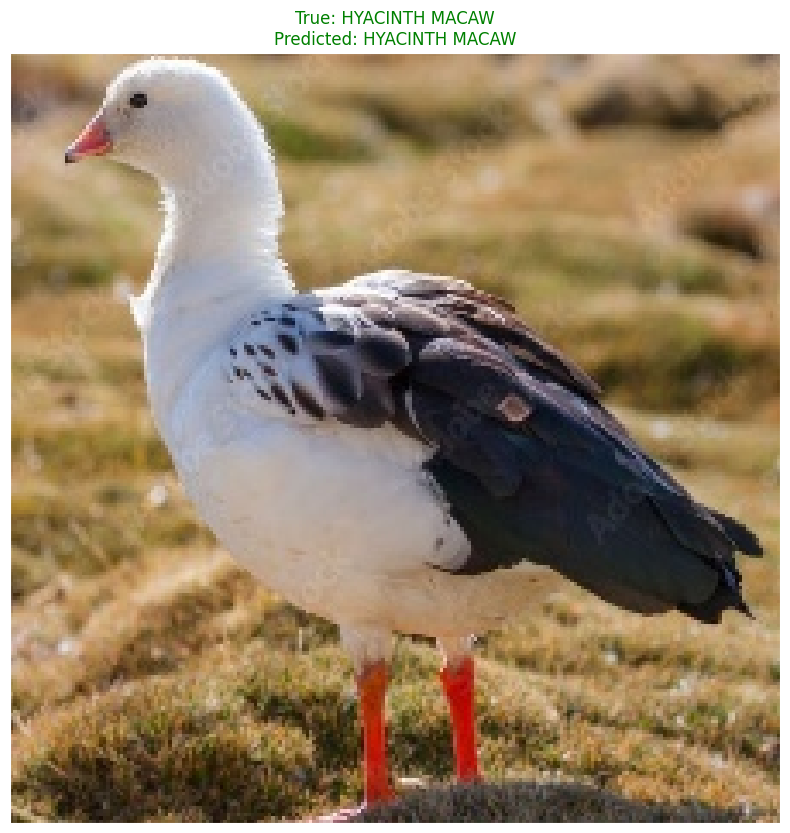

In [29]:
image_path = '/content/train/ANDEAN GOOSE/001.jpg'  # Укажите полный путь к вашему изображению
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

ax = axes
ax.imshow(plt.imread(image_path))
if test_df.Label.iloc[index] == pred[index]:
    color = "green"
else:
    color = "red"
ax.set_title(f"True: {test_df.Label.iloc[index]}\nPredicted: {pred[index]}", color=color)
plt.show()
